# Medical Project

### Lars Olsen and Oda Kristensen


## Part One - Historical Data
In this project we are given we are given a dataset of 10 000 patients. For each patient $\textit{t}$ we can see their attribute $x_t = \{x_{t,1},x_{t,2},\dots, x_{t,130}\}$, where $x_{t,1}$ represents the gender, $x_{t,2}$ represents the whether or not the pasient smoke, $\{x_{t,3},\dots,x_{t,128}\}$ represents the patient's genes and $\{x_{t,129},x_{t,130}\}$ represents the sympotms the patient displays. Note the all the varaibles are binary, that is $x_{t, \cdot } \in \{ 0,1\}$. We are also given the historical action $a_t \in \{ 0,1\}$ which represents wheter the pasient was given a placebo or a treatment, respectively. Finally, we are given the historical outcome $y_t\in \{ 0,1\}$, whether the passient displayed measurable effects after the treatment. Note that later in the project, part 3, we will expand the action varaible to take on values between 0 and 129, that is, $a_t \in \{ 0,1,2,\dots,129\}$. Where action 2 represents a new general treatment while the rempaing treatments are gene specific treatments. I.e. they are more effective against only a small porportion of the patients.

Throughout this project we want to find a policy that maximizes the utility, given by the mean of the rewards. 
$$\text{Utility} = \frac{1}{T}\sum_t^T r_t = \frac{1}{T}\sum_t^T (-0.1a_t + y_t).$$

The reward function implies that there is a small penalty associated with the use of a treatment. Thus, the policy should be somewhat certain that a treatment will yield a positive result before recommending it. If we omit this term, all our models recommend the treatment 100% of the time, since the estimated reward of the treatment is higher than the placebo, as we will come back to soon. This penealty can reflect the cost of a treatment. Say that treatment 1 is cheaper than treatment 2, but the second treatment is better. Then we should use the cheap one when we think that it suffices. When we do not think it is adequate we will use the second treatment.

Later, when we introduce the new actions we let the penalty be the same for all treatments. That is, we do not use the value of $a_t$, but apply the penealty of $-0.1$ if we use a treatment. It is not realistic that all the treatments have the same cost, but if we use the action above we get that $a_t = 100$ will yield a reward of $-10$ or $-9$ depending on the outcome. Since we want to maximize the utility we will never end up using the actions correnspong to a high $a_t$. We did not want to make up random cost for each drug, hence we choose a fixed cost for all the treatments.

We start by importing some packages and modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from scipy.stats import norm
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

We read the files:

In [3]:
features = pd.read_csv('historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('historical_Y.dat', header=None, sep=" ").values

In this part of the project we are only interested in the features. The first 128 features are what we obsere; sex, smoker and 126 genes. The 2 last attributes are the symptoms and these can be taken to be akin to labels in supervised learning.

In [4]:
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

We take a look at the observations of the 1st pacient, sex = 0, and non smoker.

In [5]:
observations[0]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0], dtype=int64)

We divide our data set into a traing set and a test set.

In [6]:
obs_train, obs_test, lab_train, lab_test = train_test_split(observations, labels, test_size=0.25)

Let's look at the distribution of symptoms:

(array([3590.,    0.,    0., 3166.,    0.,    0.,  418.,    0.,    0.,
         326.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

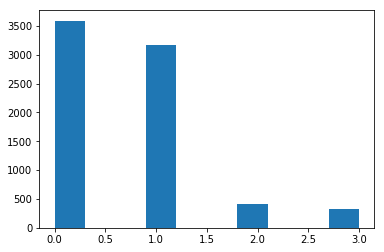

In [7]:
plt.hist(lab_train)

We now take a look at the histogram of observation. 

([array([3762.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3738.]),
  array([5436.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2064.]),
  array([3709.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3791.]),
  array([3688.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3812.]),
  array([3725.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3775.]),
  array([3744.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3756.]),
  array([3803.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3697.]),
  array([3759.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3741.]),
  array([3797.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3703.]),
  array([3786.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3714.]),
  array([3712.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         3788.]),
  array([3

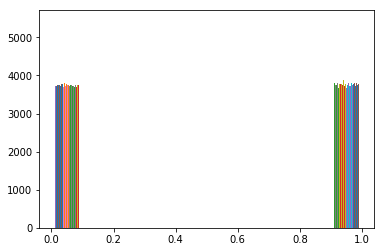

In [9]:
plt.hist(obs_train)

We talked to Summaya Mumtaz in the lab and she said that from this plot we could se that there are two clusters. We are not sure how she did that. For us it just seems that each attribute takes either the value of zero or one, as we know they do from the definition of the data. If we look at only one attribute at the time we agreee that we have two clusters. Take $x_2$, either they smoke ($x_2=1$) or not ($x_2=0$), so we have to clusters. But when we have more dimensions I feel like we have more clusters. Say we look at the two first attributes. Then a person can be either male or female and the can smoke or not smoke, i.e. we have four potential combinations. Think of a square with a cluster in each corner. obviously it can be that there are no female smokers. Then we have three clusters. Then we can think of the clusters as being on a line. Male smokers are more similar to male non-smokers than female non-smokers, and male non-smokers are equally similar to both (assuming equal weighting of the attributes). So we have "male smokers" -- "male non-smokers" -- "female non-smokers". In a hypercube we would still have clusters in each corner, and this gives us $2^{128}$ potential clusters. This is an astronomical number. So we must assume that there is pattern in the data, which will lower this number. 

From the two histograms bellow we see that there are more people of the sex zero and more non-smokers.

C:\Users\lars9\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


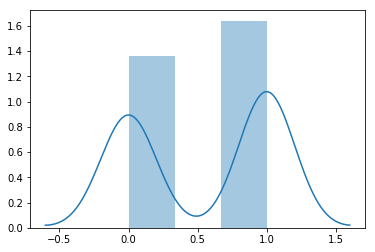

In [10]:
sns.distplot(obs_train[0])

C:\Users\lars9\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


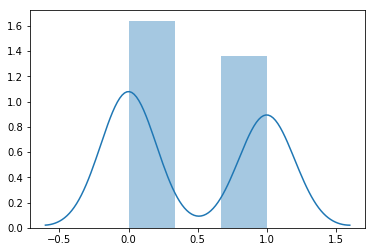

In [11]:
sns.distplot(obs_train[1])

Let's look at the proportions of smokers among sex 0. 

C:\Users\lars9\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


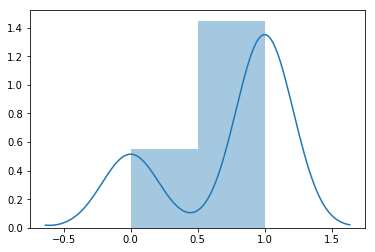

In [12]:
sns.distplot(obs_train[1][obs_train[0] == 0])

Let's look at the proportions of smokers among sex 1.

C:\Users\lars9\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


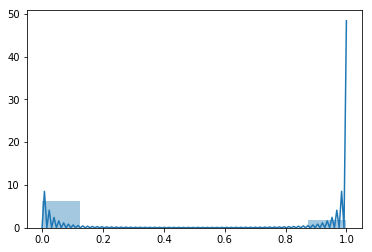

In [13]:
sns.distplot(obs_train[1][obs_train[0] == 1])

We see that there is a higher percentage of sex=0 that smoke than sex=1 that smoke.

### Let's now take a look at the scores with Kmeans

In [16]:
elbows_score = np.zeros(21) 
for k in range(1,21):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(obs_train)
    
    # Sum of distances of samples to their closest cluster center.
    inertia = kmeans_model.inertia_
    
    elbows_score[k] = interia/k
    
    print("k = %2d: Inertia = %f   Score = %f   Elbow = %f" % (k,inertia,kmeans_model.score(obs_test), inertia/k))

k =  1: Interia = 239535.284667   Score = -79854.425911   Elbow = 239535.284667
k =  2: Interia = 217696.774049   Score = -72646.060011   Elbow = 108848.387024
k =  3: Interia = 205758.149279   Score = -68926.579037   Elbow = 68586.049760
k =  4: Interia = 197814.025944   Score = -66307.475261   Elbow = 49453.506486
k =  5: Interia = 191592.603877   Score = -64231.594262   Elbow = 38318.520775
k =  6: Interia = 186423.684485   Score = -62304.008934   Elbow = 31070.614081
k =  7: Interia = 181982.207000   Score = -60967.342666   Elbow = 25997.458143
k =  8: Interia = 178136.679937   Score = -59713.792270   Elbow = 22267.084992
k =  9: Interia = 174866.422370   Score = -58809.068558   Elbow = 19429.602486
k = 10: Interia = 172316.123149   Score = -58061.353930   Elbow = 17231.612315
k = 11: Interia = 169863.354789   Score = -57229.266099   Elbow = 15442.123163
k = 12: Interia = 167763.886097   Score = -56531.099477   Elbow = 13980.323841
k = 13: Interia = 165695.515811   Score = -55934.2

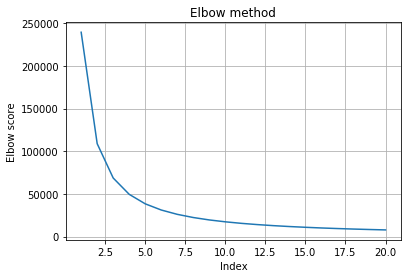

In [33]:
x = np.array([i for i in range(1,21)])

fig, ax = plt.subplots()
ax.plot(x, elbows_score[1:21])

ax.set(xlabel='Index', ylabel='Elbow score',
       title='Elbow method')
ax.grid()
plt.show()

We want this score as high as possible. The k with the best score is the k we should chose, i.e. the optimal number of clusters. The problem is that this score will keep incresing to zero when k increase. This is because score look at the distance from each point to the closest cluster centrum (for the test data, Ineteria does the same for the training data), and train and test set takes the same possible values this is a problem. Since then $2^{128}$ will (potentially) be the best k. Usually this score starts to level of, that the increase in absolute value decrese. So one can usually pick a resoanble K, but we are unsure where such a cap should be choosen here. Interia is much bigger due to the bigger dataset. One need to look at -score.

Say that K = 6 is a nice treeshold. We take a closer look at K = 6.

In [17]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(obs_train)

In [18]:
kmeans_model.score(obs_test)

-62687.212628782916

In [19]:
for l in range(6):
    print("Number of people in cluster %d: %d" %(l,sum(kmeans_model.labels_ == l)))

Number of people in cluster 0: 1274
Number of people in cluster 1: 1131
Number of people in cluster 2: 1369
Number of people in cluster 3: 1385
Number of people in cluster 4: 1128
Number of people in cluster 5: 1213


We see that the people are fairly divided between the clusters.

In [20]:
for k in range(1,21):
    gm_model = GaussianMixture(n_components=k, max_iter = 200, random_state=1).fit(obs_train)
    
    print("k = %2d: Score = %f" % (k, gm_model.score(obs_test)))

k =  1: Score = -32.603439
k =  2: Score = -27.188233
k =  3: Score = -25.275091
k =  4: Score = -24.016455
k =  5: Score = -21.425464
k =  6: Score = -18.076322
k =  7: Score = -20.838692
k =  8: Score = -18.565873
k =  9: Score = -15.420511
k = 10: Score = -18.877297
k = 11: Score = -21.430816
k = 12: Score = -19.669526
k = 13: Score = -19.959870
k = 14: Score = -16.383825
k = 15: Score = -19.406439
k = 16: Score = -19.771687
k = 17: Score = -21.365973
k = 18: Score = -21.447191
k = 19: Score = -19.663103
k = 20: Score = -22.821534


We now do the same as before but also take a look at the Bic score to find the optimal value. We have done this because of. http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py It was wrong of us to look at BicTest. One should only look at BicTrain. The optimal value is 3. But, 2 is not far of. And since we know that is the truth we go for it.

In [17]:
for k in range(1,10):
    gm_model = GaussianMixture(n_components=k, max_iter = 200, random_state=1).fit(obs_train)
    bic = gm_model.bic(obs_train)
    aic = gm_model.aic(obs_train)
    print("k = %2d: ScoreTrain = %.3f   ScoreTest = %.3f   Bic = %.3f   Aic = %.3f" % (k, gm_model.score(obs_train),gm_model.score(obs_test), bic, aic))

k =  1: ScoreTrain = -31.373   ScoreTest = -32.359   Bic = 545399.189   Aic = 487359.622
k =  2: ScoreTrain = -24.810   ScoreTest = -26.926   Bic = 521777.915   Aic = 405691.858
k =  3: ScoreTrain = -20.511   ScoreTest = -24.019   Bic = 532103.217   Aic = 357970.670
k =  4: ScoreTrain = -17.173   ScoreTest = -22.056   Bic = 556844.621   Aic = 324665.584
k =  5: ScoreTrain = -13.436   ScoreTest = -19.714   Bic = 575616.057   Aic = 285390.530
k =  6: ScoreTrain = -12.238   ScoreTest = -20.020   Bic = 632465.142   Aic = 284193.125
k =  7: ScoreTrain = -9.678   ScoreTest = -218.665   Bic = 668870.530   Aic = 262552.023
k =  8: ScoreTrain = -7.701   ScoreTest = -217.959   Bic = 714044.179   Aic = 249679.183
k =  9: ScoreTrain = -1.213   ScoreTest = -12.901   Bic = 691539.330   Aic = 169127.844


From the values above we see that k=13 is the best choice, but k=6 is not that far off, and since 6 is much lower we conclude that with Gaussian Mixture models the 'optimal' choice is 6 clusters. If we look at the score. But AIC and BIC is betther. Here we see that 2 or 3 is optimal.

In [19]:
gm_model = GaussianMixture(n_components=2, max_iter = 200, random_state=1).fit(obs_train)

In [ ]:
gm_model.predict(obs_)


#### We look at kmeans_silhouette_analysis

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [122]:
for n_clusters in range(2,11):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(obs_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(obs_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.08789046555225062
For n_clusters = 3 The average silhouette_score is : 0.07400565765849043
For n_clusters = 4 The average silhouette_score is : 0.06795148893837454
For n_clusters = 5 The average silhouette_score is : 0.06463853037241843
For n_clusters = 6 The average silhouette_score is : 0.06346335792308268
For n_clusters = 7 The average silhouette_score is : 0.06442224067814628
For n_clusters = 8 The average silhouette_score is : 0.06535853448402974
For n_clusters = 9 The average silhouette_score is : 0.06588064103198324
For n_clusters = 10 The average silhouette_score is : 0.06493274114857885


We see that the score stabilize after 4 clusters.

### Final choice of clusters and features
In the R file OptimalKAndFeatureImportance.R we have calculated the best choice of K and the most important features, based on SilhouetteScore and the importance score from randomforest, respectively. From now on we use the values obtained there. We got that 2 is the optimal number of clusters (see SilhouetteScore.png and SilhouetteScoreAfterFeatureReduction.png) and $x_{6}$, $x_4$, $x_{114}$, $x_{12}$, $x_{84}$, $x_2$ and $x_{56}$ are the most important feautres, in that order. Recall that python counts from 0, so this means columns 5, 3, 113, 11, 83, 1 and 55. 

Start by dividing the people into 2 clusters.

In [24]:
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(obs_train)

In [26]:
kmeans_model.labels_

array([0, 0, 1, ..., 1, 0, 0])

In [36]:
train_obs_0 = obs_train[kmeans_model.labels_ == 0]
train_obs_1 = obs_train[kmeans_model.labels_ == 1]
train_lab_0 = lab_train[kmeans_model.labels_ == 0]
train_lab_1 = lab_train[kmeans_model.labels_ == 1]

In [32]:
train_obs_0.shape

(3609, 128)

In [40]:
train_lab_0.shape

(3609,)

We now plot the histogram and see that there are more people with symptoms 1 and 3 in the 0 cluster. 
And there are more people with symptoms 0 and 2 in cluster 1.

(array([1269.,    0.,    0., 2071.,    0.,    0.,   95.,    0.,    0.,
         174.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

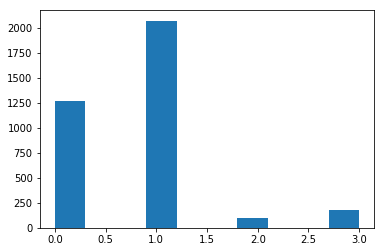

In [38]:
plt.hist(train_lab_0)

(array([2338.,    0.,    0., 1086.,    0.,    0.,  327.,    0.,    0.,
         140.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

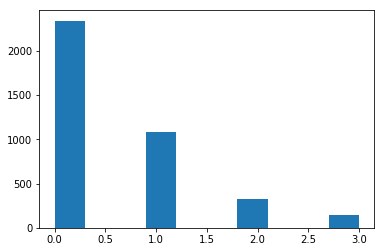

In [39]:
plt.hist(train_lab_1)

# Question 2

Next, we want to observe the effects of two different therapeutic interventions, one of which is placebo, and the other is an experimental drug. First we calculate the success of the two treatments in the whole data set. Here we assume that treatment 0 is placebo and treatment 1 is active treatment, but it could very well be the other way around. We also assume that Y = 1 means that the patient is cured, and Y = 0 means that the patient is not cured. 

In [76]:
#I want pandas
features = pd.read_csv('historical_X.dat', header=None, sep=" ")
actions = pd.read_csv('historical_A.dat', header=None, sep=" ")
outcome = pd.read_csv('historical_Y.dat', header=None, sep=" ")


active_treatments = 0
success_placebo = 0
success_active = 0

active_treatments = sum(actions.loc[:,0])


for i in range(len(actions)):
    if actions.loc[i,0] == 1 and outcome.loc[i,0] == 1:
        success_active += 1
    elif actions.loc[i,0] == 0 and outcome.loc[i,0] == 1:
        success_placebo += 1


print("The effectiveness of placebo is: %f " %(success_placebo/(10000-active_treatments)))
print("The effectiveness of active treatment is: %f " %(success_active/(active_treatments)))

The effectiveness of placebo is: 0.008959 
The effectiveness of active treatment is: 0.588338 


We see that the treatment is effective in 58.8% of the cases for treatment 1, and 0.9% effective for treatment 0. 

Next, we want to investigate whether there are some parameters that effect the outcome of the treatment. I.e. if there are some genes or other parameters that affect the effect of the treatment. From previous parameter selection, we found that the most important features were $X_2$, $X_4$, $X_6$, $X_{12}$, $X_{56}$, $X_{84}$, $X_{114}$. To find out if there is some interaction between some parameters, we choose these features and also include the action feature, and do logistic regression for models with interactions with parameter selection. For code see $\texttt{LogRegInteract.R}$

The text above is the output from R after we have done a parameter selection using BIC, allowing interactions of second order. We see here that the only interaction term including $A$, kept by the feature selection is the interaction between $X_84$ and $A$. The interaction term is positive, meaning that the treatment is more successfull when the $X_84$ feature is present. We repeat this process, but this time using AIC as selection criterion and get the following model. 


From this model, it does not seem like any features have a negative interaction with $A$, meaning that treatment1 will be effective for all features. However we do observe that some features and some feature combinations seems to have a negative effect on the result of the treatment. In both the AIC and the BIC model, the presence of the $X2$ feature influences the result of the treatment in a negative way, meaning that these patients are less likely of being cured. Also, both models indicate that the feature combination of $X_4$ and $X_6$ influence the result of the treatment in a negative way. Based on this, we would always recommend the active treatment.  

We would also like to investigate whether the clusters found by K-means clustering are affected differently by the treatment. We found that two clusters were the optimal number of clusters. We choose to do this on the whole data set, so that all the data are divided into one of the two clusters. We are not sure whether this is the correct approach, or if we should only fit the test data, so please correct us if we are wrong. For this, we repeat the procedure of the first part of Question 2, but this time dividing the data into the two clusters. 

In [138]:
# First fit a K-means
kmeans = KMeans(n_clusters = 2, random_state = 1).fit(obs_train)

#Divide observations into two clusters. 
cluster = kmeans.predict(observations)  
index_cluster0 = np.where(cluster == 0) 
index_cluster1 = np.where(cluster == 1)

actions_cluster0 = actions.iloc[index_cluster0]
outcome_cluster0 = outcome.iloc[index_cluster0]

actions_cluster1 = actions.iloc[index_cluster1]
outcome_cluster1 = outcome.iloc[index_cluster1]

active_treatments0 = sum(actions_cluster0.loc[:,0])
active_treatments1 = sum(actions_cluster1.loc[:,0])

#First cluster 0:
#Successfull and active treatments if both are 1
success_active0 = np.sum(np.multiply(actions_cluster0.values, outcome_cluster0.values))
#Successfull, active treatments if outcome is 1, but active is 0
success_placebo0 = np.sum(outcome_cluster0.values) - success_active0

print("The effectiveness of placebo in cluster 0 is: %f " %(success_placebo0/(actions_cluster0.shape[0]-active_treatments0)))
print("The effectiveness of active treatment in cluster 0 is: %f " %(success_active0/(active_treatments0)))        

#Cluster 1
success_active1 = np.sum(np.multiply(actions_cluster1.values, outcome_cluster1.values))
success_placebo1 = np.sum(outcome_cluster1.values) - success_active1

print("The effectiveness of placebo in cluster 1 is: %f " %(success_placebo1/(actions_cluster1.shape[0]-active_treatments1)))
print("The effectiveness of active treatment in cluster 1 is: %f " %(success_active1/(active_treatments1)))        

The effectiveness of placebo in cluster 0 is: 0.001202 
The effectiveness of active treatment in cluster 0 is: 0.470206 
The effectiveness of placebo in cluster 1 is: 0.018064 
The effectiveness of active treatment in cluster 1 is: 0.667636 


We see that the a bigger proportion of patients in cluster 1 are cured than in cluster 0, this apply both to the active treatment and the placebo treatment.   

As we saw in ![title](SilhouetteScoreAfterFeatureReduction.png)$\texttt{SilhouetteScoreAfterFeatureReduction.png}$, the clusters were more separated when we only kept the most important features. Maybe the differences in effect of treatment between the two clusters will be even more apparent if we cluster the observations based on only these most important features. 

In [143]:
important_features = features[[1, 3, 5, 55, 83 , 113]]
if_train, if_test = train_test_split(important_features, test_size=0.25)

kmeans_if = KMeans(n_clusters=2, random_state=1).fit(if_train)
cluster_if = kmeans_if.predict(important_features)


index_cluster0_if = np.where(cluster_if == 0) 
index_cluster1_if = np.where(cluster_if == 1)

actions_cluster0_if = actions.iloc[index_cluster0_if]
outcome_cluster0_if = outcome.iloc[index_cluster0_if]

actions_cluster1_if = actions.iloc[index_cluster1_if]
outcome_cluster1_if = outcome.iloc[index_cluster1_if]


active_treatments0_if = sum(actions_cluster0_if.loc[:,0])
active_treatments1_if = sum(actions_cluster1_if.loc[:,0])


#First cluster 0:
#Successfull and active treatments if both are 1
success_active0_if = np.sum(np.multiply(actions_cluster0_if.values, outcome_cluster0_if.values))
#Successfull, active treatments if outcome is 1, but active is 0
success_placebo0_if = np.sum(outcome_cluster0_if.values) - success_active0_if


print("The effectiveness of placebo in cluster 0 is: %f " %(success_placebo0_if/(actions_cluster0_if.shape[0]-active_treatments0_if)))
print("The effectiveness of active treatment in cluster 0 is: %f " %(success_active0_if/(active_treatments0_if)))        


#Cluster 1
success_active1_if = np.sum(np.multiply(actions_cluster1_if.values, outcome_cluster1_if.values))
success_placebo1_if = np.sum(outcome_cluster1_if.values) - success_active1_if

print("The effectiveness of placebo in cluster 1 is: %f " %(success_placebo1_if/(actions_cluster1_if.shape[0]-active_treatments1_if)))
print("The effectiveness of active treatment in cluster 1 is: %f " %(success_active1_if/(active_treatments1_if)))        






The effectiveness of placebo in cluster 0 is: 0.010493 
The effectiveness of active treatment in cluster 0 is: 0.578473 
The effectiveness of placebo in cluster 1 is: 0.007727 
The effectiveness of active treatment in cluster 1 is: 0.614173 


These numbers are different from the ones we got previously, when all the features were included. We were hoping to find bigger differences between the clusters using only the most important features, however, the effect of the treatment is more similar between the two clusters when the observations are clustered only by the important features. 

### A small look at feature selction on the historical data with python-code

Since the analysis above was done with $\texttt{R}$ and it is written that this exercise has to be done in python we include a small section on how we also can look at feature selection in python.

Here we use scikit learn's $\texttt{SelectKBest}$ to scores the features using a the $\texttt{chi2}$ function. Chi-squared is suited for classification tasks with non-negative features, which fits our scenario. In the cede below we look at both the 10 best scores and all the significant explanatory variables. From the printout we see that 102 of the variables are significant, have a p-value of less than 0.05. 

We have also created 250 trees from $\texttt{ExtraTreesClassifier}$ and from this we look at the feature importances of each of the varaibles in this ensamble of trees. Here we see that there is an overlap with the results from the $\texttt{SelectKBest}$-method. Both methods agree that $x_{130}, x_{128}, x_{129}, x_{102}$ are the 4 most important features, in descending order. That means that the treatment and the sympotms are the most important factors for wether or not the patient displays measuable effects after the treatment. The order of the other variables can be shifted in the two methods due to, e.g. high correlation between the variables, but we have not done any further investigation into that. 

Note that we now obtained different results than with the methods we used in $\texttt{R}$. 

In [25]:
import pandas
features2 = pandas.read_csv('historical_X.dat', header=None, sep=" ")
features2['a'] = pandas.read_csv('historical_A.dat', header=None, sep=" ")

X, y = features2.values, outcome
X.shape

(10000, 131)

In [43]:
k_best = SelectKBest(chi2, k=2).fit(X, y)

# Let's look at the 10 best scores
# High score is better
b = np.argsort(-k_best.scores_)[:10]
print("The 10 variables with best score: ")
print(b)
print(k_best.scores_[b])

# Let's look at the best p-values. A low p-value indicate that the explanatory variable is significant.
# We set the significance limit at 0.05 = 5e-02
print("\nThe 10 most significant vairables")
b = np.argsort(k_best.pvalues_)[:103]
print(b)
print(k_best.pvalues_[b])


The 10 variables with best score: 
[130 128 129 102  55   5 126  44  52 101]
[3753.63263455  617.44078638  504.95725172  270.78275622  207.93236283
  200.7152214   192.89502425  174.65142505  165.34247839  161.54590066]

The 10 most significant vairables
[130 128 129 102  55   5 126  44  52 101  69 123  94 125   7  48  84  43
  97  50  46   3   2  28  10  72  42  85  11  60  83  93 107 110  23 119
  15  49  24 113  90  22  66  73  63  91 120  95  53  16 124  26 105  71
  31  20  45 103  58  41  68  78  59  19  89 108  70  27  29  18 117  21
  12  62  65  77  61  17 118 114 104  51  30 111  92 109  13  88  34  64
  98  35   8  75  14  38  79  82 122  87  54   0  57]
[0.00000000e+000 2.69388243e-136 7.93200355e-112 7.66146540e-061
 3.88128940e-047 1.45799468e-045 7.42051836e-044 7.13389823e-040
 7.70010748e-038 5.19873280e-037 3.77305985e-036 4.47491319e-036
 6.35297613e-035 1.35183836e-033 5.10005660e-033 7.50601148e-033
 2.95759765e-032 7.90761948e-032 1.66939946e-030 3.56119654e-030
 

Let's now look at the case where create an ensamble of 250 trees and look at the importance of the variables in these trees. 

In [47]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=250)
clf = clf.fit(X, np.ravel(y))
b = np.argsort(-clf.feature_importances_)[:10]
print("The ten variables with highest scores:")
print(b)
print(clf.feature_importances_[b])

The ten variables with highest scores:
[130 128 129 102 101 127  44   7  50  48]
[0.33894289 0.04216753 0.03049841 0.02313356 0.01016434 0.01011807
 0.00936744 0.00915148 0.0080901  0.00803173]


# Part Two - Improved Policies
### Exercise 1 (Meassuring utility)
#### 1. Measure the utility of $\pi_0$ on the historical data.

In [29]:
# Actions is an array of 0's and 1's, representing 'placebo' and 'experimantal drug', respectively.
print(actions)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [32]:
# Outcome is an array of 0' and 1's, representing 'no effect' and 'measurable effect', respectively.
print(outcome)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


The utility function is given as
$$\sum_t r_t = \sum_t (-0.1a_t + y_t).$$
Here the -0.1 factor implies that the active treatment must be at least 10% more effective than the placebo for the utility to be better for the experimental drug than the placebo. We look at the utility of $\pi_0$ on the historical data.

In [34]:
U = np.sum(-0.1*actions + outcome)
U

1191.2

We see that the utility is 1191.2. We are not confident on wheter or not this is a good result. One should note that $t$ span from 1 to 10 000. So the maximal utility we can achieve is 10 000. However, it that scenario we give placebos to all the patients and we see a measuarble effect in all of them, which is highly unlikely. We see that giving a patient the experimental drug decrease the utility, if not the experimental drug affect the outcome in a postive direction. 

The exercise asks for the expected utility. We cannot calculate it exactly, but we can estimate it from the data. That is what we have done above. Below we describe it futher.
$$\hat{E[U]} = E_{data}[U] = \sum_t (-0.1E_{data}[a_t] + E_{data}[y_t])$$ where $E_{data}[a_t] = \sum(0p(a_t=0) + 1p(a_t=1)) = \sum (\frac{\# a_t = 1}{\# a_t})$ and $E_{data}[y_t] = \sum(0p(y_t=0) + 1p(y_t=1)) = \sum (\frac{\# y_t = 1}{\# y_t})$.

In [70]:
perc1out = np.sum(outcome==1)/len(outcome)
perc1out 

0.1421

In [71]:
perc1act = np.sum(actions==1)/len(actions)
perc1act

0.2298

In [72]:
10000*(-0.1*perc1act + perc1out)

1191.2

Which was the same as we got above, as expected.
We have also implemented this in the python file we have delivered.
Simply call policy.estimate_utility(features, actions, outcome).

#### 2. Provide error bounds on the expected utility
To provide error bounds on the expected utility we use bootstraping. We create $B$ datasets by sampling from the original data $10 000$ times with replacement. For each of the $B$ dataset we calculate the expected utility. To get, let's say, a 95% error bound we look at the 2.5% and 97.5% quantile.

In [61]:
B = 500
results = np.zeros(B)

for b in range(B):
    n = len(outcome)
    indices = np.random.choice(n, n)
    outcome_bootstrap = outcome[indices]
    action_bootstrap = actions[indices]
    results[b] = np.sum(-0.1*action_bootstrap + outcome_bootstrap)

In [62]:
bounds = np.percentile(results, [2.5, 97.5])
bounds

array([1127.9075, 1261.5225])

From this we see that a 95% CI for the utility is $[1127.9075, 1261.5225]$. So the utility of $\pi_0$ is well inside these error bounds.

### Exercise 2 (Improved policies)

#### 1.

We want to improve the policy, so that we can increase the utility. For the model, we choose a neural network and logistic regression, which we fit by first making an object of the classes $\texttt{NNRecommender}$ and $\texttt{LogisticRecommender}$, in the file $\texttt{TestRecommender.py}$, where we set the reward function to what it is defined as in the project description. We then call the policies' $\texttt{fit_treatment_outcome}$-function, so that our policies are trained on the historical data. To find the estimated utility of these improved models, we call $\texttt{policy_NN.estimate_utility(features, None, None, policy.NN)}$ and $\texttt{policy_logistic.estimate_utility(features, None, None, policy.logistic)}$. Note that when a $\texttt{policy}$ argument is given to the $\texttt{estimate_utility}$-function, the $\texttt{policy}$ will recommend an action, and it is these actions (and the probabilities of the different outomes) that are used to calculate the estimated utility.   



#### 2.
Run $\texttt{TestRecommender.py}$ to see the results. Below you can see the last printout from $\texttt{TestRecommender.py}$. From this we see that both logistic regression and neural network are better than the historical policy.

In [7]:
import pandas

features = pandas.read_csv('historical_X.dat', header=None, sep=" ").values
actions = pandas.read_csv('historical_A.dat', header=None, sep=" ").values
outcome = pandas.read_csv('historical_Y.dat', header=None, sep=" ").values
n = features.shape[0]

import NNRecommender
policy_factory_NN = NNRecommender.NNRecommender
policy_NN = policy_factory_NN(2, 2)

import LogisticRecommender
policy_factory_logistic = LogisticRecommender.LogisticRecommender
policy_logistic = policy_factory_logistic(2, 2)

def reward_function(action, outcome):
    return -0.1*action + outcome

# First we need to set the reward
policy_NN.set_reward(reward_function)
policy_logistic.set_reward(reward_function)

## Fit the policy on historical data 
policy_NN.fit_treatment_outcome(features, actions, outcome)
policy_logistic.fit_treatment_outcome(features, actions, outcome)

# Utility of the historical policy. Deterministic, so no difference if we call with policy_NN or policy_logistic
utility_hist = policy_NN.estimate_utility(features, actions, outcome)/n

# Utility of new policy
utility_new_policy_NN = policy_NN.estimate_utility(features, None, None, policy_NN)/n
utility_new_policy_logistic = policy_logistic.estimate_utility(features, None, None, policy_logistic)/n

# Utility of improved policy, using a neural network trained on the historical data
print("\nThe historical utility was %2f" %(utility_hist))
print("The estimated utility of the improved NN policy is: %2f " % (utility_new_policy_NN))
print("The estimated utility of the improved logistic policy is: %2f"  % (utility_new_policy_logistic))

Fitting treatment outcomes
Neural Network estimating utility   1000 of 10000
Neural Network estimating utility   2000 of 10000
Neural Network estimating utility   3000 of 10000
Neural Network estimating utility   4000 of 10000
Neural Network estimating utility   5000 of 10000
Neural Network estimating utility   6000 of 10000
Neural Network estimating utility   7000 of 10000
Neural Network estimating utility   8000 of 10000
Neural Network estimating utility   9000 of 10000
Neural Network estimating utility  10000 of 10000
Logistic model estimating utility   1000 of 10000
Logistic model estimating utility   2000 of 10000
Logistic model estimating utility   3000 of 10000
Logistic model estimating utility   4000 of 10000
Logistic model estimating utility   5000 of 10000
Logistic model estimating utility   6000 of 10000
Logistic model estimating utility   7000 of 10000
Logistic model estimating utility   8000 of 10000
Logistic model estimating utility   9000 of 10000
Logistic model estimati

# Part Three - Adaptive Experiment Design

In this part part we are going to test our recommenders on new patients and evaluate the results. We do this by using the $\texttt{test_policy}$ function. It creates a fixed number of patients, ask the recommenders what treatments each indivdual should recive and then calculate the outcome. At the end it let the recommender obsereve the outcome. 

In [51]:
def test_policy(generator, policy, reward_function, T, seed = None, printout = False, print_index = 100, actions=False):
    policy.set_reward(reward_function)
    u = 0
    
    # Variable to count the number of people who were given a treatment
    total_given_treatment = 0
    
    # For reproducibility we allow the user to set the seed
    if (seed != None):
        np.random.seed(seed)
        
    # Record the number of each treatments 
    if (actions == True):
        actions_count = np.zeros(129)
    
    for t in range(T):
        # We generate 1 new pasient
        x = generator.generate_features()
        
        # Find the best action, from our model
        a = policy.recommend(x)
        
        if (actions == True):
            actions_count[a] += 1

        # If given a treatment, then we record it
        if (a != 0): 
            total_given_treatment += 1
            
        # Generate the outcome based on user_data and action
        y = generator.generate_outcome(x, a)
       
        # Add the utility/reward
        u += reward_function(a, y)
        
        # Let the policy now about the result/refit the model.
        policy.observe(x, a, y)
        
        # A small printout
        if ((printout) & (t % print_index == 0)):
            print("Iteration: %6d \t Current mean reward: %7.4f" %(t, u/(t+1)))
    
    if (actions):
        return [u/T, total_given_treatment, actions_count] 
    else:
        return [u/T, total_given_treatment] 

As discussed in the introduction we use a slightly modified $\texttt{reward_function}$.

In [50]:
def reward_function(action, outcome):
    # Here we use the alternative reward_function discussed in the introduction.
    # That is, we assume all medicins have the same cost and that they must be 10% more efficient than the placebo.
    if (action >= 1): 
        return -0.1 + outcome
    else: 
        return outcome

To verify the results one should let each recommender run several times. There is a high variability in the results. That means that the results from two consecutive simulations can yield quite different results. Hence it is important to create empiraical confidence intervals for the utility. We have not computed the variance of the empirical data, since this is indirectly visable from the range of the confidence intervals, but the variance is also a good measure.

In [49]:
# generator generates the data and the outcome
# policy_maker is an object that can create policies
# reward_function calculate the reward given the action and the outcome
# T is the number of patients
# N is the number of times we should treat T patients
# features are the historical features
# actions are the historical actions
# outcome are the historical outcome
# extra is extra arguments for the policy
def create_CI(generator, policy_maker, reward_function, T, N, features, actions, outcome, extra = None):
    res = np.zeros((N,2))
    for n in range(N):
        # Create a policy from the policymaker
        if (extra == None):
            policy = policy_maker(generator.get_n_actions(), generator.get_n_outcomes())
        else:
            policy = policy_maker(generator.get_n_actions(), generator.get_n_outcomes(), extra)
            
        # Set the reward function
        policy.set_reward(reward_function)
        
        # Fit the model
        policy.fit_treatment_outcome(features, actions, outcome)
        
        # Record the results
        res[n] = test_policy(generator, policy, reward_function, T, seed = 27183+n)
        
        if(n % 10 == 0):
            print("Done with n = %d" % n)

    print("Utility percentiles(2.5, 50, 97.5): ", np.percentile(res[:,0], [2.5, 50, 97.5]))
    print("Percentage of treatments percentiles(2.5, 50, 97.5): ", np.percentile(res[:,1], [2.5, 50, 97.5])/T)

### Exercise 3 - online policy testing


#### 1.

Here we create a $\texttt{HistoricalRecommender}$ recommender and test it on the testbench. Recall that the $\texttt{HistoricalRecommender}$ recommends based on the frequency of recommendations in the historical dataset. That is, if the percentage of people given the placebo in the historical data is $30\%$, then our recommender will also recommend placebo in $30\%$ of the cases. 

In hindsight we are uncertain if we mayhaps misinterpreted this model. The idea might have been that we should have used the historical dataset to find the person in this dataset who is most similar to the new patient and give the new patient the same treatment as the historical patient. This could have been done with a KNN with K=1.

Whether or not we misinterpreted it, our model yields close to the historical results. Hence we are quite certain that what we have done is correct.

In [53]:
import data_generation
generator = data_generation.DataGenerator()

In [11]:
import HistoricalRecommender
policy_factory_historical = HistoricalRecommender.HistoricalRecommender

T = 500
N = 100
create_CI(generator, policy_factory_historical, reward_function, T, N, features, actions, outcome)

Done with n = 0
Done with n = 10
Done with n = 20
Done with n = 30
Done with n = 40
Done with n = 50
Done with n = 60
Done with n = 70
Done with n = 80
Done with n = 90
Utility percentiles(2.5, 50, 97.5):  [0.08799 0.1064  0.13249]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.202   0.23    0.26305]


As we can see above we get a bite wider interval than in the previous part, but note that the median is close to the historical utility and that our $95\%$ empirical confidence interval cover the results from the historical part.
Note that the the historical recommender prescibe treatments to about a fifth of the patients.

#### 2.
Here we are going to look at the improved recommenders. Note that we 


We also create some "stupid" recommenders to have more recommenders to compare our improved policies with. 
We have created a $\texttt{FixedTreatmentRecommender}$ and a $\texttt{RandomRecommender}$. These should be self explanatory, but they always recommend a fixed treatment(placebo or treatment1, defined in the initializtion) or does a random choice.


In [13]:
import FixedTreatmentRecommender
policy_factory_fixed = FixedTreatmentRecommender.FixedTreatmentRecommender

import RandomRecommender
policy_factory_random = RandomRecommender.RandomRecommender

T = 500
N = 100

print("Always placebo: ")
create_CI(generator, policy_factory_fixed, reward_function, T, N, features, actions, outcome, extra = 0)

print("\nAlways treatment1: ")
create_CI(generator, policy_factory_fixed, reward_function, T, N, features, actions, outcome, extra = 1)

print("\nRandom treatment: ")
create_CI(generator, policy_factory_random, reward_function, T, N, features, actions, outcome, extra = 2)

Always placebo: 
Utility percentiles(2.5, 50, 97.5):  [0.004   0.012   0.02105]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0. 0. 0.]

Always treatment1: 
Utility percentiles(2.5, 50, 97.5):  [0.39695 0.432   0.476  ]
Percentage of treatments percentiles(2.5, 50, 97.5):  [1. 1. 1.]

Random treatment: 
Utility percentiles(2.5, 50, 97.5):  [0.19066  0.2237   0.257115]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.45495 0.503   0.54105]


Since we in this case we know how the outcomes are generated, that is, we have access to $\texttt{big_generating_matrices.mat}$ and the $\texttt{data_generation}$ we can create an $\texttt{OptimalRecommender}$ that recommends the optimal treatment. From the two files we see that the outcome is decided based on the the sign of the dot product between the user and the recommended action. If the the dot product is positive then $y_t = 1$ and if the dot product is negative then $y_t = 0$. The optimal policy will then chose the action with highest dot product, given that it is positive, else it will recommend the placebo to maximize the reward (to escape the penatlity of using a treatment).   

In [14]:
import OptimalRecommender
policy_factory_optimal = OptimalRecommender.OptimalRecommender

T = 500
N = 100

print("Optimal: ")
create_CI(generator, policy_factory_optimal, reward_function, T, N, features, actions, outcome, extra = 2)

Optimal: 
Utility percentiles(2.5, 50, 97.5):  [0.4536 0.486  0.5292]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.504 0.54  0.588]


We see that the opt

Now we take a look at our improved policies:
Single_logistic
Bootstrap_logistic
NN_(3,2,2)
NN_(5,2)


In [20]:
# Single logistic
import LogisticRecommender
policy_factory_logistic = LogisticRecommender.LogisticRecommender

import LogisticRecommenderBoot
policy_factory_logistic_boot = LogisticRecommenderBoot.LogisticRecommenderBoot

print("Single logistic model: ")
create_CI(generator, policy_factory_logistic, reward_function, T, N, features, actions, outcome, extra = 0)

print("Bootstrap logistic model: ")
create_CI(generator, policy_factory_logistic_boot, reward_function, T, N, features, actions, outcome, extra = 0)

Single logistic model: 
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.429635 0.4667   0.500715]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.63685 0.67    0.71505]
Bootstrap logistic model: 
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.425365 0.4663   0.50262 ]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.64285 0.68    0.71705]


In [22]:
import NeuralNetworkRecommender
policy_factory_NN = NeuralNetworkRecommender.NeuralNetworkRecommender

print("NN(5,2): ")
create_CI(generator, policy_factory_NN, reward_function, T, N, features, actions, outcome, extra = [0, [5,2]])

print("NN(2,2,3): ")
create_CI(generator, policy_factory_NN, reward_function, T, N, features, actions, outcome, extra = [0, [2,2,3]])

NN(5,2): 
Done with n = 9
Done with n = 19
Done with n = 29
Done with n = 39
Done with n = 49
Done with n = 59
Done with n = 69
Done with n = 79
Done with n = 89
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.42499 0.4612  0.50504]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.4878 0.536  0.5801]
NN(2,2,3): 
Done with n = 9
Done with n = 19
Done with n = 29
Done with n = 39
Done with n = 49
Done with n = 59
Done with n = 69
Done with n = 79
Done with n = 89
Done with n = 99
Utility percentiles(2.5, 50, 97.5):  [0.42616 0.4671  0.51069]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.53495 0.578   0.6241 ]


We have also created two other improved polcies with utilize the clustert. That is, based on the the historical data it divides the poplulation into two subpopulations and fit a model on each of these. The results for the logistic cluster are nearly identical to those obtained by the non-clustered version. The clustered nerual network actually obtained a lower utility. We think this perhaps might be due to the fact that the trainingset for the individaul neural networks became too small. As we now, it takes a lot of data to fine tune a neural network. Note that the code below takes a long time to run.

In [55]:
import LogisticRecommenderCluster
policy_factory_logistic_cluster = LogisticRecommenderCluster.LogisticRecommenderCluster

# Old code so is hardcoded to (5,2) layers
import NNRecommenderCluster
policy_factory_NN_cluster = NNRecommenderCluster.NNRecommenderCluster

N = 100
T = 500

print("Logistic cluster: ")
create_CI(generator, policy_factory_logistic_cluster, reward_function, T, N, features, actions, outcome)

print("NN cluster(5,2): ")
create_CI(generator, policy_factory_NN_cluster, reward_function, T, N, features, actions, outcome)

Logistic cluster: 
Done with n = 0
Utility percentiles(2.5, 50, 97.5):  [0.313625 0.46     0.73975 ]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.56125 0.7     0.8775 ]
NN cluster(5,2): 
Done with n = 0
Utility percentiles(2.5, 50, 97.5):  [0.320125 0.425    0.675   ]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.41125 0.525   0.75   ]


To summarize the results from this exercise we have made a table. Note that the numbers might be different than the numbers above. That is becaue we have not fixed a seed so the values change slightly each time you run the code. However, since we run the code 100 times each time the differences are miniscue.

![title](Table1.png)

From the table we see that the historical recommender and the improved recommenders perform at the same level as in the previous part. When we look at the utility confidence intervals of our improved policies we see that they overlap quite a lot. This means that the models are equally good. However, one should note that the neural network recommends the drug less often but obtain the same utility. That is, the Neural Network is better at detecting patients who will respond positive to the treatment than the logistic. The logistic recommends the treatment more, so they treat more pacients but they also get more patients which doesn't respond to the treatment. Here it would have been interesting to change the penalty and see if this influence the utility. One could also here look at a confusion matrix, to analyze the percentages of false-positve, false-negative, true-positve and true-negative.

The clustered versions yield approximately the same results, and hence we have omitted them from the table.

One should also note that our improved policies are not far from the the optimal values.

The fact that by always recommending the treatment we can obtain an utility which is this close to the optimal utility is quite worring. At least in the setting where the vague terms treatments represent drugs. If we are in the case where the treatment is a sunscreen and the placebo is body lotion this 
giving the medicin results in a 95% percentile of the optimal value might it scary. 


### Exercise 4 - adaptive experiments

In this exercise we are going to look at addaptive models. That is, we let our models observe the outcome of their recommendations such that they can learn from them. Since we have used supervised methods this implies that we have to refit our model with the new data. There is probably a better way to do this, since refitting the models take a long time. One should also note that new observations might drown in the old data in the method we have used. Here one might adress issues such as whether one should weight the most resent data higher than the old data. We have not adressed this issue.

We will consider two scenarios. In the first scenario we have still only the placebo and the treatment. In the second scenario we introduced the other treatments. That is, we now have 129 treatments: 1 placebo, 2 general treatments and 126 gene specific treatments. Note that we in this scenario we do not have any data for the new treatments. Thus, one have to explore these new treatments and look at the results. This we will do for a fixed number of treatments, and then we are going to use the best treatment for the rest. 

Here there are two potential goals according to the text: discover the most effective treatment policy at the end of the trial or maximize the expected number of people to be treated. We have gone for the second on, but with the modified $\texttt{reward_function}$ discussed earlier. 

We take a look at the first section first.
#### 1. 
We have alredy described what the code does. It adds the new patient to the old dataset and refit the model. We do this with two of the models above. This is due to the long computation time it takes to run these simulations. Since the single logistic and the bootstrap logistic obtained the same results last time we only look at the simple version here. We also only look at the (5,2) neural network. We would have liked to tested (2,2,3) too, but it takes too long time. We allow our models to observe by changing the zeros to ones in the extra, otherwise the code below is identical to the one above.

In [ ]:
# We reduce the number of patients due to the computation time
# We do noe recommend to run this block again since it takes hours to run.
N = 100
T = 100

# Optimal recommender
import OptimalRecommender
policy_factory_optimal = OptimalRecommender.OptimalRecommender

# Single logistic
import LogisticRecommender
policy_factory_logistic = LogisticRecommender.LogisticRecommender

# Nerural network
import NeuralNetworkRecommender
policy_factory_NN = NeuralNetworkRecommender.NeuralNetworkRecommender

print("Optimal: ")
create_CI(generator, policy_factory_optimal, reward_function, T, N, features, actions, outcome, extra = 2)

print("Single logistic model: ")
create_CI(generator, policy_factory_logistic, reward_function, T, N, features, actions, outcome, extra = 1)

print("NN(5,2): ")
create_CI(generator, policy_factory_NN, reward_function, T, N, features, actions, outcome, extra = [1, [5,2]])

We can see the results of the code above in the left part of the table below. Note that there is not much improvments compared to the previous table. This might be because the new information drowns in the old data or there is some underlying noise that cannot be reduced. Note that each model now only treats 100 persons, due to the computational time, hence the wider intervals. So if you want to compare the results in this table with the previous table you should look at the medians.


![title](Table2.png)


#### 2. 
In this setting we are able to choose among the 129 treatments. We initialy had some difficulites so we will first adress what we had done. 

We are informed that treatment 2 is a general treatment. So we want to compare it to the other genereal treatment; treatment 1. In some scenarios it it possible to test two treatments on a single individual, and in other cases it's impossible. E.g. you cannot donclude which of two painkillers relived you of the pain, under the assumption that both were taken by oral administration. However, you can can apply two different body lotions for dry skin on either arm and check which worked or not. In the code below we simulate the the latter scenario. 

Note that the analyis above in rooted in the real world. Since we are given the code we can treat the same patient with different treatments no mather the scenario. We also want to note that the analysis we are doing here is perhaps not applicable in the real world, since we just give them treatments and see what happens.

In [69]:
# Choose medicine 1 and 2 which we want to compare. 
# Can take values between 0 and 129, inclusive. 
# N is the number of individuals we want to compare.

def compareTwoMedicines(med1, med2, N, seed = 10):
    # Number of times medicine 1 worked 
    num1 = 0

    # Number of times medicine 2 worked
    num2 = 0

    # Number of times only medicine 2 worked
    numjust1 = 0

    # Number of times only medicine 1 worked
    numjust2 = 0

    # Number of times both medecines worked
    numboth = 0

    # Number of times neither medicine worked
    numnone = 0

    # Set seed for reproducibility
    np.random.seed(seed)
    for _ in range(N):
            # We generate 1 new pasient
            x = generator.generate_features()

            # Generate the outcome based on user_data and action
            y_1 = generator.generate_outcome(x, med1)
            y_2 = generator.generate_outcome(x, med2)

            if (y_1 == 1): num1 += 1
            if (y_2 == 1): num2 += 1
            if ((y_1 == 1) & (y_2 == 1)): numboth += 1
            if ((y_1 == 0) & (y_2 == 0)): numnone += 1
            if ((y_1 == 1) & (y_2 == 0)): numjust1 += 1
            if ((y_1 == 0) & (y_2 == 1)): numjust2 += 1
    print("Med1 = %d and med2 = %3d: %6d %6d %9d %9d %5d %6d" % (med1, med2, num1, num2, numjust1, numjust2, numboth, numnone))

In [47]:
compareTwoMedicines(1, 2, 100000)

Med1 = 1 and med2 = 2:  53553  54690  19312  20449  34241  25998


From this printout we see that there is some overlap between the two general treatments. That is, there is about $34.2\%$ of the patients who display measurable effects to both treatments. Some patients react positively to only one of the treatments while other pasients, about $26\%$ don't react positively to either treatment. This information is summeraized by the following venn diagram. 
![Venn](Venn.png)


If we do the same analysis that we did above with treatment 1 and the gene specific treatments we get some interesting results. From the printout below we see that we never observe an instance where only the gene specific treatment works. If it worked, then the general treatment 1 also worked. So, we are always better of by only recommending the placebo, treatment1 or treatment2.

In [72]:
print("                          #med1  #med2 #justmed1 #justmed2 #both  #none")
for i in range(129):
    compareTwoMedicines(1, i, 50000)

                          #med1  #med2 #justmed1 #justmed2 #both  #none
Med1 = 1 and med2 =   0:  26766    579     26187         0   579  23234
Med1 = 1 and med2 =   1:  26766  26766         0         0 26766  23234
Med1 = 1 and med2 =   2:  26766  27305      9677     10216 17089  13018
Med1 = 1 and med2 =   3:  26766    365     26401         0   365  23234
Med1 = 1 and med2 =   4:  26766    774     25992         0   774  23234
Med1 = 1 and med2 =   5:  26766    458     26308         0   458  23234
Med1 = 1 and med2 =   6:  26766    889     25877         0   889  23234
Med1 = 1 and med2 =   7:  26766    832     25934         0   832  23234
Med1 = 1 and med2 =   8:  26766    597     26169         0   597  23234
Med1 = 1 and med2 =   9:  26766   1570     25196         0  1570  23234
Med1 = 1 and med2 =  10:  26766    737     26029         0   737  23234
Med1 = 1 and med2 =  11:  26766   1631     25135         0  1631  23234
Med1 = 1 and med2 =  12:  26766    847     25919         0   847

Med1 = 1 and med2 = 113:  26766    592     26174         0   592  23234
Med1 = 1 and med2 = 114:  26766    836     25930         0   836  23234
Med1 = 1 and med2 = 115:  26766   1019     25747         0  1019  23234
Med1 = 1 and med2 = 116:  26766    639     26127         0   639  23234
Med1 = 1 and med2 = 117:  26766    782     25984         0   782  23234
Med1 = 1 and med2 = 118:  26766    718     26048         0   718  23234
Med1 = 1 and med2 = 119:  26766    735     26031         0   735  23234
Med1 = 1 and med2 = 120:  26766    667     26099         0   667  23234
Med1 = 1 and med2 = 121:  26766    240     26526         0   240  23234
Med1 = 1 and med2 = 122:  26766    896     25870         0   896  23234
Med1 = 1 and med2 = 123:  26766    782     25984         0   782  23234
Med1 = 1 and med2 = 124:  26766    625     26141         0   625  23234
Med1 = 1 and med2 = 125:  26766    675     26091         0   675  23234
Med1 = 1 and med2 = 126:  26766    917     25849         0   917

Let's now for a second assume that the gene specific treatments only target a single gene, and more precisely, that treatment 3 correspond to gene 1, treatment 4 correspond to gene 4 and so on. This might be a far fetched assumption, but it's the way we have interpreted the exercise. Then we can conduct a similar calculation as above and look at the proportions of the different genes. That is, for each patient we record wether the treatment was a success or not, and in either case we also record the value of the specific gene. We do this for 10 000 patients. From these calulations we get empirical estimates for the 1) probabilities that a given treatment is a success given the value of the genes, 2) the probabilities for a gene taking on a specific value given that the treatment was a success and 3) general success rates and failure rates. Below you see the code and the final table of the 20 "best" treatments, under the assumption that we always recommend it no mater the features and that we can give mutiple treatments to the same people.

In [89]:
def test_policy2(generator, policy, reward_function, T):
    policy.set_reward(reward_function)
    # Set seed for reproducibility
    seed_number = 333213
    # Utility
    u = 0
    # varaible to count
    number_treated_gen0 = 0
    number_treated_gen1 = 0
    number_failed_gen0  = 0
    number_failed_gen1  = 0
    
    for t in range(T):
        # For reproducibility and to analyse the same patients every time the code is called
        np.random.seed(seed_number + t)
        # We generate 1 new pasient
        x = generator.generate_features()
        # Fixed model, always give a fixed number
        a = policy.recommend(x)
        # Generate the outcome based on user_data and action
        y = generator.generate_outcome(x, a)
        # Add the utility/reward
        u += reward_function(a, y)
        
        # From the feedback after the presentation you said we should look at the proportions of gene0 and gene1 for the 
        # general treatments. Since they do not correspond to a single gen we assume that your note was reagarding the fact 
        # that we highlightet treatment 127/gene 125 and hence that we should look at these proportions.
        # We can do this by just changing the a value here and use the same code as before:
        if (a in [0,1,2]): 
            a = 127
        
        # If success or failure count the genes
        if(y == 1): 
            if (x[a] == 0):
                number_treated_gen0 += 1
            if (x[a] == 1):
                number_treated_gen1 += 1
        else:
            if (x[a] == 0):
                number_failed_gen0 += 1
            if (x[a] == 1):
                number_failed_gen1 += 1
                
        
    return [u/T, number_treated_gen0, number_treated_gen1, number_failed_gen0, number_failed_gen1] 

In [93]:
import FixedTreatmentRecommender

# matrix to store the results for the 129 medicines
results_fixed_treatment = np.zeros((generator.get_n_actions(), 5))

# Number of patients
T = 10000

# Run each model
for i in range(len(results_fixed_treatment)):
    policy_temp = FixedTreatmentRecommender.FixedTreatmentRecommender(generator.get_n_actions(), generator.get_n_outcomes(), i)
    results_fixed_treatment[i] = test_policy2(generator, policy_temp, reward_function, T)


# Let's only look at the k best gene treatments
k = 20
best_indices = np.argsort(-results_fixed_treatment[:,0])[:k]

print("Treatment  Utility  Total success: %gen0   %gen1   Total fail: %gen0   %gen1    Successrate given gen0/gen1")
for i in best_indices:
    util = results_fixed_treatment[i,0]
    suc0 = results_fixed_treatment[i,1]
    suc1 = results_fixed_treatment[i,2]
    fail0 = results_fixed_treatment[i,3]
    fail1 = results_fixed_treatment[i,4]
    tot_suc = suc0 + suc1
    tot_fail = fail0 + fail1
    tot = tot_suc + tot_fail
    percentage_suc0 = suc0 / tot_suc
    percentage_suc1 = suc1 / tot_suc
    percentage_fail0 = fail0 / tot_fail
    percentage_fail1 = fail1 / tot_fail
    percentage_0_succ = suc0/(suc0+fail0)
    percentage_1_succ = suc1/(suc1+fail1)
    if (i in [0,1,2]):
        print("%9d  %7.3f        %4d     %4.3f   %4.3f        %3d  %7.3f  %6.3f   %6.3f %6.3f (ratios of gene 125)" % (i, util, tot_suc, percentage_suc0, percentage_suc1, tot_fail, percentage_fail0, percentage_fail1,  percentage_0_succ, percentage_1_succ))
    else:
        print("%9d  %7.3f        %4d     %4.3f   %4.3f        %3d  %7.3f  %6.3f   %6.3f %6.3f " % (i, util, tot_suc, percentage_suc0, percentage_suc1, tot_fail, percentage_fail0, percentage_fail1,  percentage_0_succ, percentage_1_succ))


Treatment  Utility  Total success: %gen0   %gen1   Total fail: %gen0   %gen1    Successrate given gen0/gen1
        2    0.444        5443     0.305   0.695        4557    0.548   0.452    0.400  0.647 (ratios of gene 125)
        1    0.434        5341     0.457   0.543        4659    0.368   0.632    0.588  0.496 (ratios of gene 125)
        0    0.014         140     0.564   0.436        9860    0.414   0.586    0.019  0.010 (ratios of gene 125)
      127   -0.009         906     0.091   0.909        9094    0.448   0.552    0.020  0.141 
       86   -0.040         603     0.221   0.779        9397    0.531   0.469    0.026  0.096 
       28   -0.062         380     0.463   0.537        9620    0.493   0.507    0.036  0.040 
       26   -0.063         368     0.139   0.861        9632    0.517   0.483    0.010  0.064 
       11   -0.065         354     0.136   0.864        9646    0.516   0.484    0.010  0.062 
        9   -0.067         334     0.266   0.734        9666    0.512   

As in our presentation we want to highlight treatment 127, corresponding to gene 125. If we know the treatment was a success, then we can with a high probability, more precise $91\%$, assume that the value of gene 125 was 1. However, this doesn't mean that we should give treatment 127 to a pasient with the value of gene 125 being 1, since the successrate is only $14.1\%$, while the successrates for the general treatments are much higher. 
Note that the table display the successrates of the general treatment given gene 125 and they are both better independently of the value of gene 125. These values are only comparable with treatment 127. From them we see that there is a higher successrate for treatment 1 if gene 125 is 0, while the successrate of treatment 2 is higher if the gene has a value of 1.

This whole analysis has been a huge digression, but that is something we did after we made some models which became worse when we introduced the new treatments. We had initaially assumed that our results would become better with the new treatments, which we have concluded is wrong. Hence when we do an exploration later on, we are losing potential utility which we are not able to re-earn. Once again, we highlight this, since we have the generator file we can look at it. If we let the $\texttt{OptimalRecommender}$ recommend between action zero to two or zero to 129, we obtain the same results. Again, this is not possible in the real world, but since we are working in a sandbox scenario we wanted to make a note of it.

In [106]:
T = 500
N = 100

print("Optimal (129 treatments): ")
create_CI(generator, policy_factory_optimal, reward_function, T, N, features, actions, outcome, extra = generator.get_n_actions())
print("Optimal (3 treatments): ")
create_CI(generator, policy_factory_optimal, reward_function, T, N, features, actions, outcome, extra = 3)

Optimal (129 treatments): 
Done with n = 0
Done with n = 10
Done with n = 20
Done with n = 30
Done with n = 40
Done with n = 50
Done with n = 60
Done with n = 70
Done with n = 80
Done with n = 90
Utility percentiles(2.5, 50, 97.5):  [0.632655 0.6624   0.693945]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.70295 0.736   0.77105]
Optimal (3 treatments): 
Done with n = 0
Done with n = 10
Done with n = 20
Done with n = 30
Done with n = 40
Done with n = 50
Done with n = 60
Done with n = 70
Done with n = 80
Done with n = 90
Utility percentiles(2.5, 50, 97.5):  [0.632655 0.6624   0.693945]
Percentage of treatments percentiles(2.5, 50, 97.5):  [0.70295 0.736   0.77105]


Let's forget this for a moment and rather illustrate how we obtained the results we presentated at the seminar, table 2. That is, where we let the the improved polcies take on values zero, one and two. Let's start by looking at the neural network. Initialy we thought we had to manually force it to explore the second treatment, but after some simulations we figured out that we actually obtained the best results by not forcing the neural network to recommend the second general treatment. Why this is, we are not certain of. Maybe NN are exporationary by nature or we might just been lucky. Either way, the new policy recommend treatments much more often than before and obtain a median utility of 0.622 which is pretty close to the optimal value of 0.666. 
The NN recommends the action, among the three, that maximizes the estimated reward of the patient.

Our results with the logistic model did not work as we had intended. It uses the same idea as above to choose it recommendations, but it ends up always chosing the second treatment. We do not think there is an error in the code, but it is strange that the confidence intervals have zero width. Under the assumption that our code is correct is that the model is too optimistic on the effect of the treatment and that the coefficient corresponding to the action variable is positive, hence it chooses the second action. 

In the presentation we highlighted this issue and presented a possible solution, which would be to use dummy variables for the action. Your feedback was that that might work, but you recommended us to have a seperate model for each action. We have looked into this and will presentate our findings later in the paper.


In [ ]:
# We do not reccommend to run this chunk. It is computationally heavy and takes a long time to run.
# We ran it in the terminal, since it is faster.
T = 100
N = 100

# Optimal recommender
import OptimalRecommender
policy_factory_optimal = OptimalRecommender.OptimalRecommender

# Single logistic
import LogisticRecommender2Actions
policy_factory_logistic = LogisticRecommender2Actions.LogisticRecommender2Actions

# Nerural network
import NeuralNetworkRecommender2Actions
policy_factory_NN = NeuralNetworkRecommender2Actions.NeuralNetworkRecommender2Actions

print("Optimal: ")
create_CI(generator, policy_factory_optimal, reward_function, T, N, features, actions, outcome, extra = 2)

print("Single logistic model: ")
create_CI(generator, policy_factory_logistic, reward_function, T, N, features, actions, outcome, extra = 1)

print("NN(5,2): ")
create_CI(generator, policy_factory_NN, reward_function, T, N, features, actions, outcome, extra = [1, [5,2]])

![title](Table2.png)
![title](Table3.png)

## The new version of logistic based on presentation feedback:

We start by looking at the version of the logistic model. Here we only look at the three first actions. Note that only action 2 is unknown. Hence we force or model to explore this choice 20 times. This number should propably been decided dynamically by some method, but we lack time to do the analysis. After the first 20 patients it recommends the action with highest estimated utility. Note that the recommender now have 3 models. In the first model all the actions are 0, in the second they are 1 and in the last one we only have action 2. We did not have time to run the $\texttt{create_CI}$, so we simply ran the code with 2000 patients and looked at the utility. Since we treated so many pasients we hope that the utility has converged. From the printouts that looks to be a reasonable assumption. One should note that the recommender is still too optimistic and prescribe the treatment too often. However, it accheive the best mean utility we have observed this far.


In [13]:
import LogisticRecommender2Tips
T = 2000

policy_factory_tips = LogisticRecommender2Tips.LogisticRecommender2Tips
policy_logistic_tips = policy_factory_tips(generator.get_n_actions(), generator.get_n_outcomes(), force_alt_med = 20, force_action=2)
policy_logistic_tips.set_reward(reward_function)
policy_logistic_tips.fit_treatment_outcome(features, actions, outcome)
test_policy(generator, policy_logistic_tips, reward_function, T, 1334, printout = True)

Iteration:    0 	 Current mean reward:  0.9000
Iteration:  100 	 Current mean reward:  0.5931
Iteration:  200 	 Current mean reward:  0.6413
Iteration:  300 	 Current mean reward:  0.6276
Iteration:  400 	 Current mean reward:  0.6357
Iteration:  500 	 Current mean reward:  0.6305
Iteration:  600 	 Current mean reward:  0.6354
Iteration:  700 	 Current mean reward:  0.6389
Iteration:  800 	 Current mean reward:  0.6441
Iteration:  900 	 Current mean reward:  0.6425
Iteration: 1000 	 Current mean reward:  0.6473
Iteration: 1100 	 Current mean reward:  0.6493
Iteration: 1200 	 Current mean reward:  0.6510
Iteration: 1300 	 Current mean reward:  0.6487
Iteration: 1400 	 Current mean reward:  0.6545
Iteration: 1500 	 Current mean reward:  0.6602
Iteration: 1600 	 Current mean reward:  0.6633
Iteration: 1700 	 Current mean reward:  0.6590
Iteration: 1800 	 Current mean reward:  0.6562
Iteration: 1900 	 Current mean reward:  0.6564


[0.6565000000000086, 2000]

We tried to generalize this method to the case with 129 treatments. However, we got stuck. Since we use a logistic model we need a training set which contains instances of both outcomes, for most of the treatments we did not acchieve this even when we forced the recommender to recommend each treatment 20 times. Then we though we could remove the treatments which yielded no sucess after 20 patients. However, we ran into some coding issues and had no time to solve the bugs. We think this could have given some good results. Instead we choose to explore the 129 treatments based on a method we looked at in class, Thompson sampling, which yielded acceptable results.

### Thompson sampling
In class we devoled the $\texttt{thompson_bandit}$. It has a beta prior for each of the 129 treatments. The first two treatments we know quite a lot about, we could have found empirical parameters for the beta prior by momentmatching (set the analytic and the historical moments to be identical), but we have chosen parameters which creates the prior we ought to have. The prior for the placebo has the majority of it's weight located close to 0 while the first treatment has a more evenly distributed weight with the mode at 0.5. For the other treatments we do not know anything, hence we chose a uniform dsitribution for them. These priors will be washed away by the data. 
For each patient we draw a random value from the distributions for each of the treatments and recommend the treatment with the maximum value. From the printout below we see that the recommender first tries out the different treatments and learn from this. After some time it will figure out which treatments are the best and always go for this or these. If there is a treatment superior then it will always chose that one, but in this case both action 1 and action 2 are almost equally good(from earlier analysis), so we will recommend a mixture of them over time. This is because of the randomness by drawing a random point from the distributions.  
We see that the utility converges to around 0.443. This is as expected. From earlier analysis we showed that treatment 1 and treatment 2 was effective in about 54% of the cases. If we also include the -0.1 penalty in the utility function we end up with the utility that we see here.

In [52]:
T = 20000
import thompson_bandit

n_actions = 129
n_outcomes = 2
prior_a = [2,2] + [1]*127
prior_b = [5,2] + [1]*127
thompson_policy = thompson_bandit.ThompsonBandit(129, 2, prior_a, prior_b)
print("Thompson 20 000:")
thompson_result1 = test_policy(generator, thompson_policy, reward_function, T, 100, True, 1000, True)

print("10 most used treatments:")
b = np.argsort(-thompson_result1[2])[:10]
print("Treatment:  %5d %5d %5d %5d %5d %5d %5d %5d %5d %5d" % (b[0], b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9]))
r = thompson_result1[2][best_indices]
print("Times used: %5d %5d %5d %5d %5d %5d %5d %5d %5d %5d" % (r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8], r[9]))

T = 200000
print("\nThompson 200 000:")
thompson_policy = thompson_bandit.ThompsonBandit(129, 2, prior_a, prior_b)
thompson_result2 = test_policy(generator, thompson_policy, reward_function, T, 100, True, 10000, True)
print("10 most used treatments:")
b = np.argsort(-thompson_result2[2])[:10]
print("Treatment:  %6d %6d %5d %5d %5d %5d %5d %5d %5d %5d" % (b[0], b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9]))
r = thompson_result1[2][best_indices]
print("Times used: %6d %6d %5d %5d %5d %5d %5d %5d %5d %5d" % (r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8], r[9]))


print("\nThompson  (20 000): utility = %f" %thompson_result1[0])
print("Thompson (200 000): utility = %f" %thompson_result2[0])

Thompson 20 000:
Iteration:    0 	 Current mean reward: -0.1000
Iteration: 1000 	 Current mean reward:  0.0086
Iteration: 2000 	 Current mean reward:  0.1594
Iteration: 3000 	 Current mean reward:  0.2469
Iteration: 4000 	 Current mean reward:  0.2940
Iteration: 5000 	 Current mean reward:  0.3192
Iteration: 6000 	 Current mean reward:  0.3426
Iteration: 7000 	 Current mean reward:  0.3575
Iteration: 8000 	 Current mean reward:  0.3695
Iteration: 9000 	 Current mean reward:  0.3775
Iteration: 10000 	 Current mean reward:  0.3827
Iteration: 11000 	 Current mean reward:  0.3863
Iteration: 12000 	 Current mean reward:  0.3895
Iteration: 13000 	 Current mean reward:  0.3935
Iteration: 14000 	 Current mean reward:  0.3968
Iteration: 15000 	 Current mean reward:  0.3995
Iteration: 16000 	 Current mean reward:  0.4007
Iteration: 17000 	 Current mean reward:  0.4034
Iteration: 18000 	 Current mean reward:  0.4057
Iteration: 19000 	 Current mean reward:  0.4071
10 most used treatments:
Treatmen

# A small discussion on Privacy and Fairness

As statisticians we have to remember that data we are working on often origins from human beings and that our conclusions can effect their lives. It is therefor important to adress certain concepts such as privacy and fairness. The former is related to the fact that the data can be e.g. stolen by an adversary. This might be an insurance company which are able to identify you based on database merging and from this they might increase the insurence due to some specefic genes, hypotetically. We do not want this to happen. We might solve this by adding noise to the features. Since we are dealing with binary data this correspond to flip some of the values. However, this might also make it harder for us to give the right treatments. Say that we have a treatment that always work if the pacients have a set of genes, but it is lethal if you don't have the right genes (extremmly hypotetically case). In this scenario we have to be sure about the genes, but if the data has noise we cannot use this medicine on the patient without risking his/hers life. 

One should also adress fairness. That is that our recommender doesn't discriminate based on gender, ethnectiy, ect. In this dataset the only potential disciminative featuers are the features regarding gender and whether or not the patient smoke. In this project we are in a different setting than in the previous project and it might be a good ting to seperate based on gender. Say that treatment 1 is more effective on female while treatment 2 is more effective on men, then we would like to know the gender on the patient. However, if we are in the first setting were males more often are given placebo then women, then this might be a issue. 

We have not done any analysis on our models in this project, since we did it in the previous one, but we wanted to adress it.